In [1]:
import torch 
import torchvision 
import numpy as np

import os
import pandas as pd
import albumentations as A
import albumentations.pytorch
import cv2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# import torch.nn.functional as F

import sys
sys.path.append('../')
from dataset import val_transforms, CDataset

In [2]:
import easydict 
args = easydict.EasyDict({ "batch_size": 64, 
                          "epochs": 50, 
                          "data": 0, 
                          'lr':0.1,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':0,
                          'workers':16,
                         'print_freq':2000,
                         'saved_dir':'../trained_models/checkpoint.pt'})

In [3]:
# make saved dir
from pathlib import Path
path = Path(args.saved_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)

In [4]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

3
cuda:0


In [5]:
from augment import *

In [6]:
IMAGE_SIZE = 256
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
    A.OneOf([
        A.HorizontalFlip(p=.8),
        A.VerticalFlip(p=.8),
        A.RandomRotate90(p=.8)]
    ),
    # HEColorAugment(sigma1=.4, sigma2=5., mat=None, p=0.9),
], p=1.0) 

In [7]:
import albumentations as A
import albumentations.pytorch
import cv2

class CDataset(Dataset):
    def __init__(self, df, defaultpath='/home/beomgon/Dataset/new_patches/', transform=None):
        self.df = df
        self.transform = transform
        self.dir = defaultpath

    def __len__(self):
        return len(self.df)   

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 4]
#         print(pid)

        image = cv2.imread(self.dir + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = (image.astype(np.float32)-128.)/128.
        
#         if image is uint8, normalization by 255 is done automatically by albumebtation(ToTensor method)
        if self.transform:
            timage = self.transform(image=image)
            image = timage['image']
        
        image =  torch.tensor(image, dtype=torch.float32)/255.
        #image = (torch.tensor(image, dtype=torch.float32)-128)/128
        image = image.permute(2,0,1)
            
        label = self.df.iloc[idx, 5]
        return image, label, path

In [8]:
train_df = pd.read_csv('../dataframe/train_New_Stomach_df.csv')
df_shuffled=train_df.iloc[np.random.permutation(train_df.index)].reset_index(drop=True)
train_dataset = CDataset(df_shuffled[:2000], defaultpath='/home/beomgon/Dataset/seegene/new_patches/', 
                        transform=train_transforms)

val_df = pd.read_csv('../dataframe/val_New_Stomach_df.csv')
val_dataset = CDataset(val_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/',
                       transform=val_transforms)  

test_df = pd.read_csv('../dataframe/test_New_Stomach_df.csv')
test_dataset = CDataset(test_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/',
                        transform=val_transforms)  

In [9]:

# df_shuffled[:2000].label_id.value_counts()

In [10]:
image, label, path = next(iter(train_dataset))
# image

In [11]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)


In [12]:
# images, labels, paths = next(iter(train_loader))
# images.shape

In [13]:
import torchvision.models as models
# from resnet import resnet18
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 3)
torch.nn.init.normal_(model.fc.weight, std=0.01)
torch.nn.init.constant_(model.fc.bias, 0.)
default_state_dict = model.state_dict()
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=args.weight_decay)
optimizer = torch.optim.SGD(
       params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
# optimizer = torch.optim.SGD(params, lr=args.lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30], 
                                                    gamma=0.2)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
criterion = nn.CrossEntropyLoss().to(device)

In [14]:
from main import *

In [15]:
ratio = [.8, .8, .8]
acc_list = []
test_acc = []

for num in range(len(ratio)) :
    args.saved_dir = '../trained_models/resnet8/stomach1_2' + str(num) + '/checkpoint.pt'
    path = Path(args.saved_dir.split('checkpoint')[0])
    path.mkdir(parents=True, exist_ok=True)  
    
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(512, 3)
    torch.nn.init.normal_(model.fc.weight, std=0.01)
    torch.nn.init.constant_(model.fc.bias, 0.)    
    # model.load_state_dict(default_state_dict)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
#     optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=args.weight_decay)
    optimizer = torch.optim.SGD(
           params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 30, 40], 
                                                        gamma=0.2)
    # criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_acc1 = 0
    acc1 = 0
    train_loss = []
    val_acc = []

    for epoch in range(args.epochs):
#         print('lr', optimizer.param_groups[0]['lr'])
        losses = train(train_loader, model, criterion, optimizer, epoch, args)
        scheduler.step()

        # evaluate after every epoch
        acc1 = validate(val_loader, model, criterion, args)   
        val_acc.append(acc1.item())

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1) 

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict(),
        }, is_best, filename=args.saved_dir)   
        
    checkpoint = torch.load(args.saved_dir)
    model.load_state_dict(checkpoint['state_dict'])
    acc1 = validate(test_loader, model, criterion, args)    
    print('************* test number {} ratio {} acc{} *************'.format(num, ratio[num], acc1))    
    acc_list.append(val_acc)    
    test_acc.append(acc1)
    

Epoch: [0][ 0/32]	Time  2.018 ( 2.018)	Data  1.450 ( 1.450)	Loss 1.0853e+00 (1.0853e+00)	Acc@1  46.88 ( 46.88)
Test: [  0/406]	Time  1.279 ( 1.279)	Loss 4.0768e+00 (4.0768e+00)	Acc@1  39.06 ( 39.06)
 * Acc@1 40.607
Epoch: [1][ 0/32]	Time  1.198 ( 1.198)	Data  1.118 ( 1.118)	Loss 1.1262e+00 (1.1262e+00)	Acc@1  35.94 ( 35.94)
Test: [  0/406]	Time  1.243 ( 1.243)	Loss 1.0461e+00 (1.0461e+00)	Acc@1  40.62 ( 40.62)
 * Acc@1 40.996
Epoch: [2][ 0/32]	Time  1.111 ( 1.111)	Data  1.050 ( 1.050)	Loss 1.0649e+00 (1.0649e+00)	Acc@1  39.06 ( 39.06)
Test: [  0/406]	Time  1.485 ( 1.485)	Loss 1.1251e+00 (1.1251e+00)	Acc@1  48.44 ( 48.44)
 * Acc@1 41.331
Epoch: [3][ 0/32]	Time  1.279 ( 1.279)	Data  1.183 ( 1.183)	Loss 1.0805e+00 (1.0805e+00)	Acc@1  40.62 ( 40.62)
Test: [  0/406]	Time  1.305 ( 1.305)	Loss 1.0398e+00 (1.0398e+00)	Acc@1  50.00 ( 50.00)
 * Acc@1 46.135
Epoch: [4][ 0/32]	Time  1.616 ( 1.616)	Data  1.548 ( 1.548)	Loss 1.0191e+00 (1.0191e+00)	Acc@1  45.31 ( 45.31)
Test: [  0/406]	Time  1.217 (

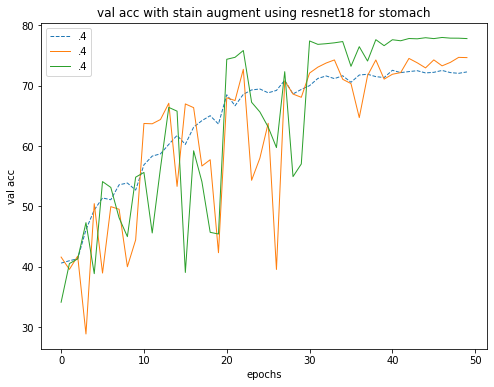

[tensor(75.0711, device='cuda:0'), tensor(76.4138, device='cuda:0'), tensor(80.9643, device='cuda:0')]


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(args.epochs)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['lines.linewidth'] = 1
plt.plot(epochs, acc_list[0], linestyle='--')
plt.plot(epochs, acc_list[1])
plt.plot(epochs, acc_list[2])
# plt.plot(epochs, acc_list[3])
plt.legend(['.4', '.4', '.4' ])
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.title('val acc with stain augment using resnet18 for stomach')
# plt.axis([10, 30, 88, 94])
plt.show()
print(test_acc)